# [7.6 Residual Networks (ResNet)](https://d2l.ai/chapter_convolutional-modern/resnet.html)

paper : [Deep Residual Learning for Image Recognition (He et al. 2016a)](https://ieeexplore.ieee.org/document/7780459) <br>
paper : [Identity Mappings in Deep Residual Networks (He et al. 2016b)](https://arxiv.org/abs/1603.05027)


## Residual / Shortcut Connection


<img src='./images/fig_7.6.2.png' width='400'/>

<br>

<img src='./images/slide_resnet.png' width='850'/>

## Implementation in Pytorch

In [1]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
plt.rc('font', size=16)
import time

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Residual block

In [2]:
class Residual(nn.Module):  # @save
    """The Residual block of ResNet."""
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        
        self.bn2 = nn.BatchNorm2d(num_channels)
        
    def forward(self, X):
        '''
        
          X -> conv1 -> BN1 -> ReLU  ->  conv2 -> BN2  -------> Y -> ReLU -> output
            |                                            |+ X
            |__________________(1x1 conv3)_______________|
          
        '''
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

### check the output of residual block

In [3]:
# output shape = input

blk = Residual(3, 3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [4]:
# output spatial dimension = 1/2 * input's channel dimension (set stride = 2)
# output channel dimension =  2  * input's channel dimension 

blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

## ResNet Model

<img src='./images/fig_7.6.4.png' width='800'/>

In [5]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [6]:
def resnet_block(input_channels, num_channels, num_residuals,
                 first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

In [7]:
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

In [8]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

In [9]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [10]:
net.to(device)
net

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Residual(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm2d(64, eps=1e-

In [11]:
# count total network parameters
print('Total network parameters :', sum(param.numel() for param in net.parameters() if param.requires_grad))

Total network parameters : 11178378


In [12]:
### Load FashionMNIST dataset and apply data transform, make input dimension 28x28 -> 96x96

transform = transforms.Compose([transforms.Resize([96, 96]),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor()])

fmnist_train = datasets.FashionMNIST(
    root="../../../data", train=True, transform=transform, download=True)
fmnist_test = datasets.FashionMNIST(
    root="../../../data", train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(fmnist_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(fmnist_test, batch_size=batch_size, shuffle=True)

images, labels = next(iter(train_loader))
images.shape

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


torch.Size([64, 1, 96, 96])

In [13]:
### Loss function
criterion = nn.CrossEntropyLoss()

In [14]:
### Optimizer
learning_rate = 0.001

# optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate, betas=(0.9, 0.999))

In [15]:
### Training function

def train_1_epoch(model, optimizer, train_loss, train_acc):
    
    model.train()             # set model to training mode

    running_loss = 0.
    running_corrects = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device) 
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        
        # loss
        loss = criterion(outputs, labels) # predicted outputs v.s. actual labels
        
        # backwards
        optimizer.zero_grad()  # zero gradient
        loss.backward()        # loss.backward would calculate dloss/dw_i  
        optimizer.step()       # update network parameters (w_i)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
        
        #if (i+1)%300 == 0: # every 300 steps, print something
        #    print(f'epoch {epoch+1}/{num_epochs}, step {i+1}/{len(train_loader)}, loss={loss.item():.4f}')
            
    epoch_loss = running_loss / len(fmnist_train)            ; train_loss.append(epoch_loss)
    epoch_acc  = running_corrects / len(fmnist_train) * 100. ; train_acc.append(epoch_acc)
    print(f'>>> End epoch {epoch+1}, train accuracy = {epoch_acc:.2f}%, train avgLoss = {epoch_loss:.4f}')

    
    
def validation(model, valid_loss, valid_acc):
    
    model.eval()              # set model to evaluation mode
    
    running_loss = 0.
    running_corrects = 0
    
    for i, (images, labels) in enumerate(test_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        
        # compute statistics (avg. loss, accuracy)
        running_loss += loss.item() * labels.size(0)
        _, predictions = torch.max(outputs, 1)
        running_corrects += torch.sum(predictions == labels.data)
    
    valid_loss.append(running_loss/len(test_loader.dataset))
    valid_acc.append(running_corrects/len(test_loader.dataset) * 100.)
    print(f'>>>              valid accuracy = {valid_acc[-1]:.2f}%, valid avgLoss = {valid_loss[-1]:.4f}')

In [16]:
train_loss = []
train_acc = []
valid_loss = []
valid_acc = []

num_epochs = 10
for epoch in range(0, num_epochs):
    since = time.time()
    
    train_1_epoch(net, optimizer, train_loss, train_acc)
    validation(net, valid_loss, valid_acc)
    
    time_elapsed = time.time() - since
    print(f'\tTime: {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')

>>> End epoch 1, train accuracy = 84.50%, train avgLoss = 0.4192
>>>              valid accuracy = 81.65%, valid avgLoss = 0.4536
	Time: 0m 38s
>>> End epoch 2, train accuracy = 89.86%, train avgLoss = 0.2726
>>>              valid accuracy = 83.69%, valid avgLoss = 0.4418
	Time: 0m 39s
>>> End epoch 3, train accuracy = 91.24%, train avgLoss = 0.2356
>>>              valid accuracy = 88.74%, valid avgLoss = 0.3045
	Time: 0m 39s
>>> End epoch 4, train accuracy = 92.15%, train avgLoss = 0.2106
>>>              valid accuracy = 91.44%, valid avgLoss = 0.2360
	Time: 0m 39s
>>> End epoch 5, train accuracy = 93.10%, train avgLoss = 0.1861
>>>              valid accuracy = 91.32%, valid avgLoss = 0.2340
	Time: 0m 39s
>>> End epoch 6, train accuracy = 93.65%, train avgLoss = 0.1729
>>>              valid accuracy = 91.12%, valid avgLoss = 0.2400
	Time: 0m 39s
>>> End epoch 7, train accuracy = 94.28%, train avgLoss = 0.1530
>>>              valid accuracy = 92.87%, valid avgLoss = 0.2027
	Time:

### Plot

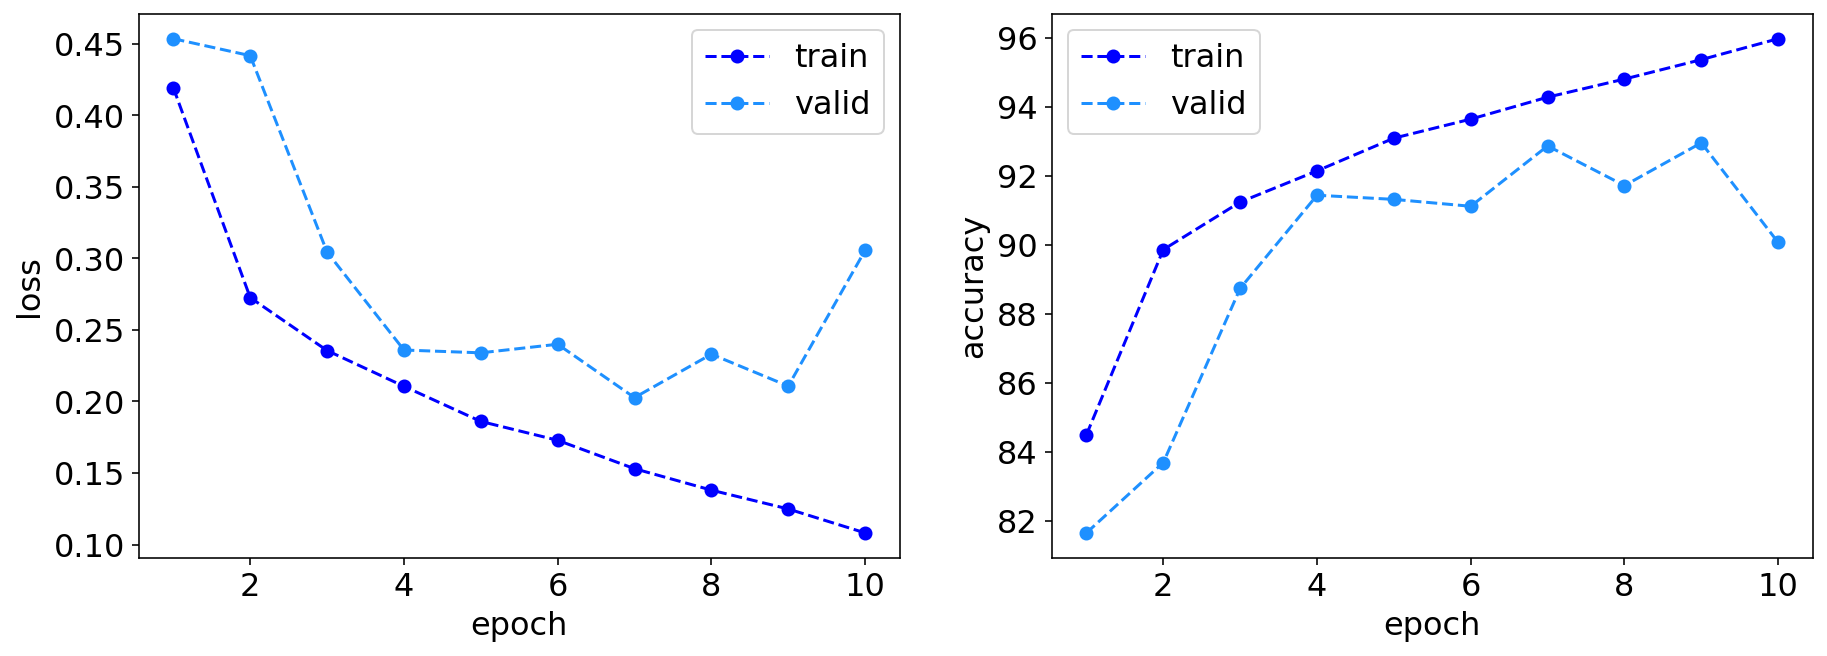

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.rc('font', size=16)

ax[0].plot(range(1,num_epochs+1)[::], train_loss[::], 'o--', label='train', color='b')
ax[0].plot(range(1,num_epochs+1)[::], valid_loss[::], 'o--', label='valid', color='dodgerblue')
ax[1].plot(range(1,num_epochs+1)[::], train_acc[::] , 'o--', label='train', color='b')
ax[1].plot(range(1,num_epochs+1)[::], valid_acc[::], 'o--', label='valid', color='dodgerblue')

ax[0].set_ylabel('loss')
ax[1].set_ylabel('accuracy')

for i in range(2):
    ax[i].set_xlabel('epoch')
    ax[i].legend(loc='best')

#### ---- check output dimensions of each blocks ---

In [19]:
X = torch.rand(size=(1, 1, 96, 96)).to(device)
print('Input b1 : ', X.shape)

for layer in b1:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Input b1 :  torch.Size([1, 1, 96, 96])
Conv2d output shape:	 torch.Size([1, 64, 48, 48])
BatchNorm2d output shape:	 torch.Size([1, 64, 48, 48])
ReLU output shape:	 torch.Size([1, 64, 48, 48])
MaxPool2d output shape:	 torch.Size([1, 64, 24, 24])


In [20]:
print('Input b2 : ', X.shape)
for layer in b2:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Input b2 :  torch.Size([1, 64, 24, 24])
Residual output shape:	 torch.Size([1, 64, 24, 24])
Residual output shape:	 torch.Size([1, 64, 24, 24])


In [21]:
print('Input b3 : ', X.shape)
for layer in b3:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Input b3 :  torch.Size([1, 64, 24, 24])
Residual output shape:	 torch.Size([1, 128, 12, 12])
Residual output shape:	 torch.Size([1, 128, 12, 12])


In [22]:
print('Input b4 : ', X.shape)
for layer in b4:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Input b4 :  torch.Size([1, 128, 12, 12])
Residual output shape:	 torch.Size([1, 256, 6, 6])
Residual output shape:	 torch.Size([1, 256, 6, 6])


In [23]:
print('Input b5 : ', X.shape)
for layer in b5:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Input b5 :  torch.Size([1, 256, 6, 6])
Residual output shape:	 torch.Size([1, 512, 3, 3])
Residual output shape:	 torch.Size([1, 512, 3, 3])
